# Featurizer

In [1]:
from cider.datastore import DataStore
from cider.featurizer import Featurizer
import sys
import os

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Load some mobile phone metadata. See {doc}`standardized data formats <../data_formats/cdr>` for file schemas. 

In [2]:
# This path should point to your cider installation, where configs and data for this demo are located.
from pathlib import Path
cider_installation_directory = Path('../../cider')

datastore = DataStore(config_file_path_string= cider_installation_directory / 'configs' / 'config_quickstart.yml')
featurizer = Featurizer(datastore=datastore, clean_folders=True)

23/05/02 12:25:19 WARN Utils: Your hostname, Leos-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.50.152 instead (on interface en0)
23/05/02 12:25:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/02 12:25:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/02 12:25:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Loading CDR...


Loading recharges...
SUCCESS!
Loading mobile data...
Loading mobile money...
Loading antennas...


Remove duplicate records, filter to just a specific date range, remove outlier days and spammers based on call and text volumes, and remove duplicate records in CDR, recharges, mobile data records, and mobile money records.

In [3]:
# Deduplication
featurizer.ds.deduplicate()

# Filter to just January 1 - February 28 (inclusive)
featurizer.ds.filter_dates('2020-01-01', '2020-02-28')

# Remove transactions involving spammers who place 1.8+ calls/texts per active day
spammers = featurizer.ds.remove_spammers(spammer_threshold=1.8)

Number of spammers identified: 19


In [4]:
# Remove all records from days more than 2 standard deviations from the mean transaction volume
outlier_days = featurizer.ds.filter_outlier_days(num_sds=2)

Outliers removed: 2020-01-24, 2020-02-06


/Users/leo/Documents/gpl/cider/cider/datastore.py:446: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  timeseries = timeseries.groupby('day', as_index=False).agg('sum')


Produce summary statistics and plots.

In [5]:
print(featurizer.diagnostic_statistics())

{'CDR': {'Days': 59, 'Transactions': 91299, 'Subscribers': 981, 'Recipients': 981}, 'Recharges': {'Days': 59, 'Transactions': 9315, 'Subscribers': 783}, 'Mobile Data': {'Days': 59, 'Transactions': 9388, 'Subscribers': 592}, 'Mobile Money': {'Days': 59, 'Transactions': 5513, 'Subscribers': 682, 'Recipients': 700}}


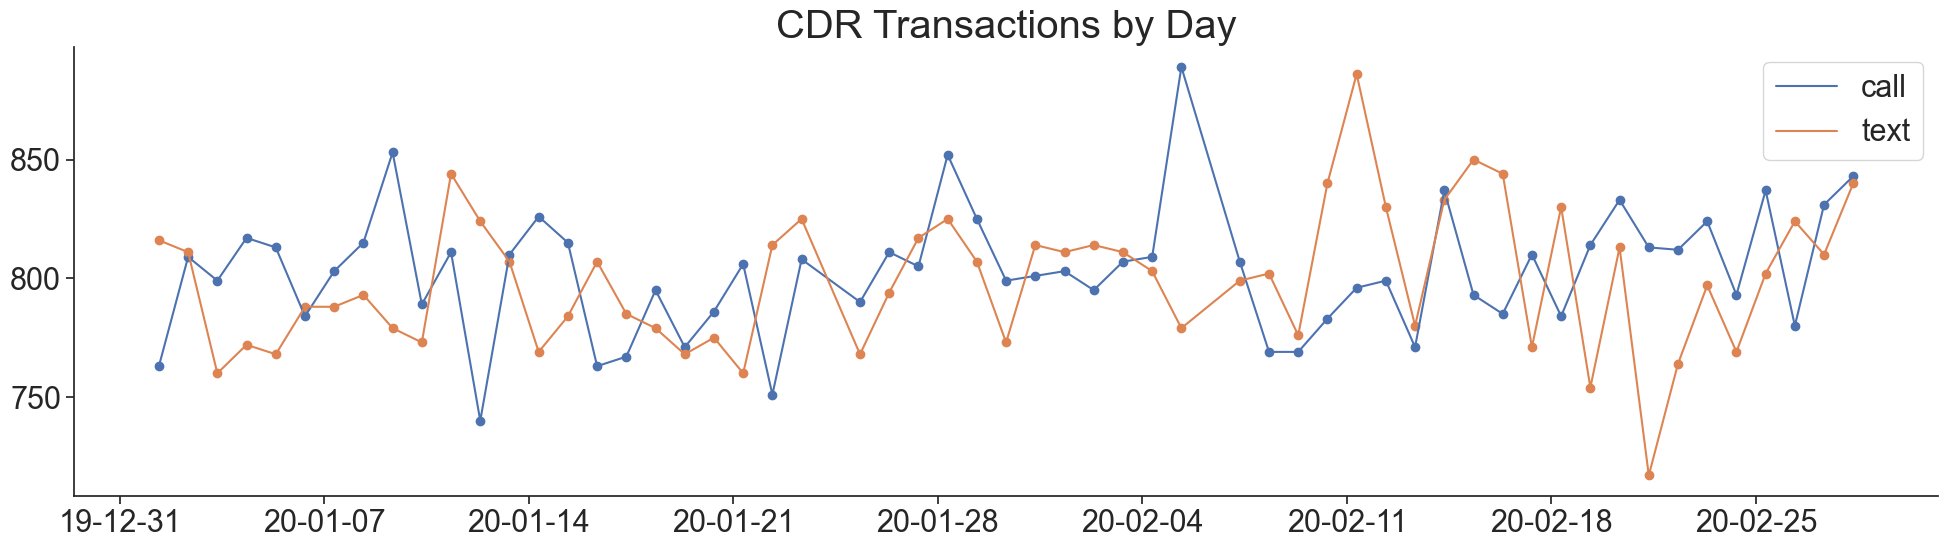

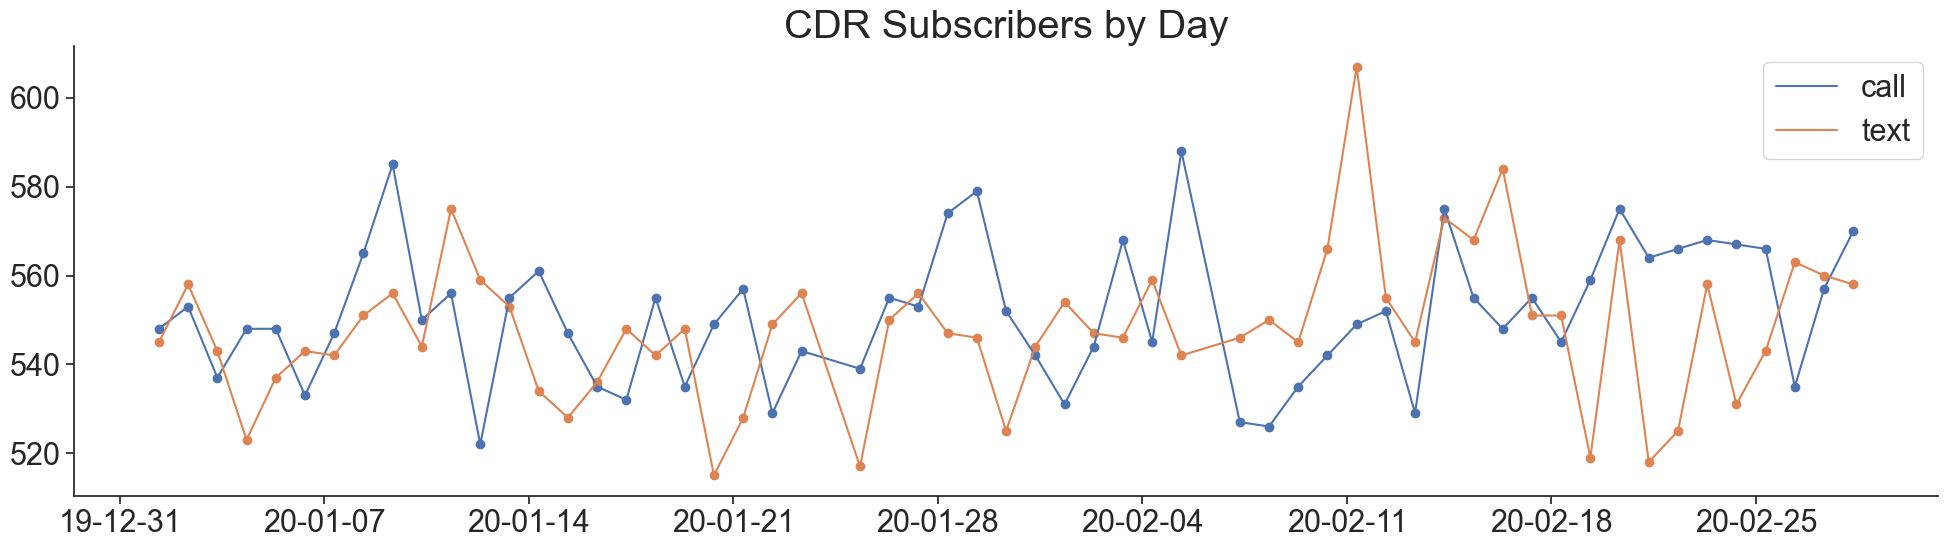

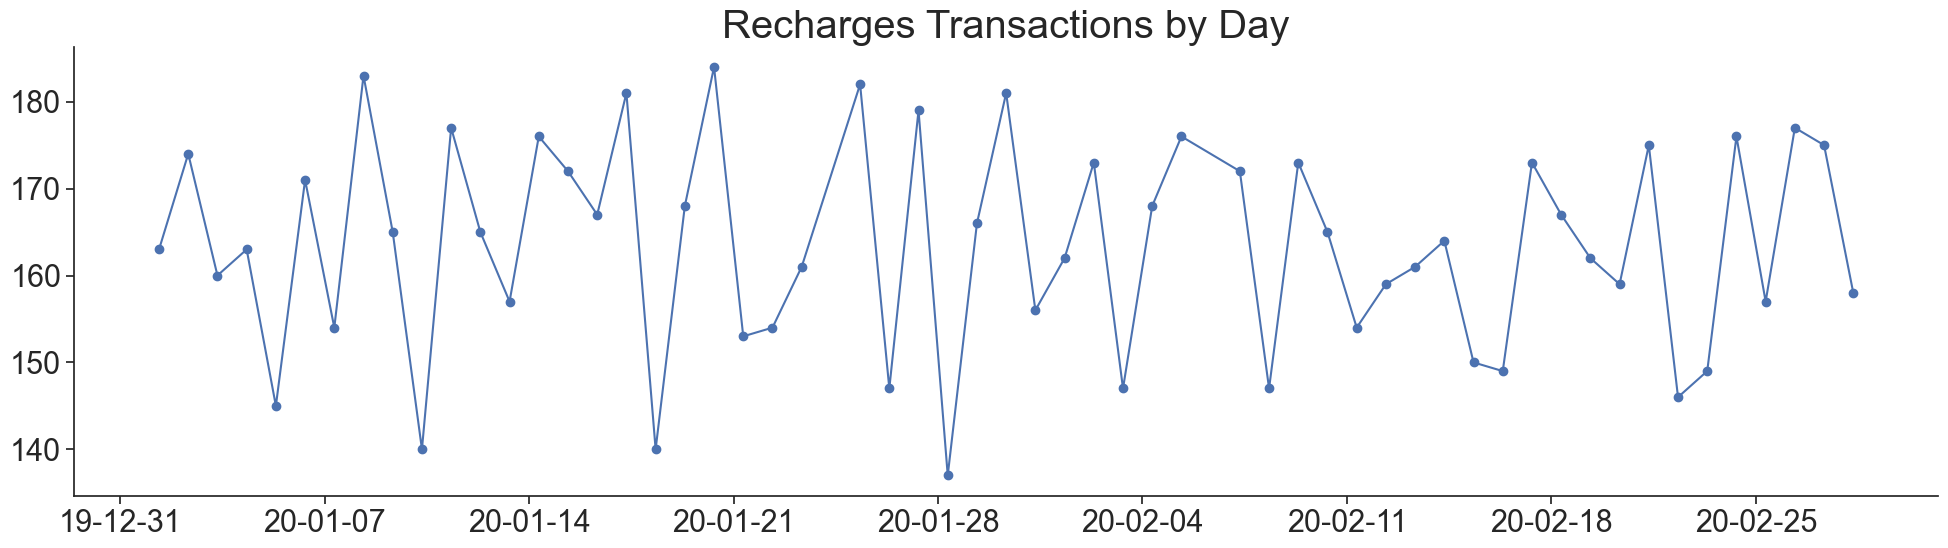

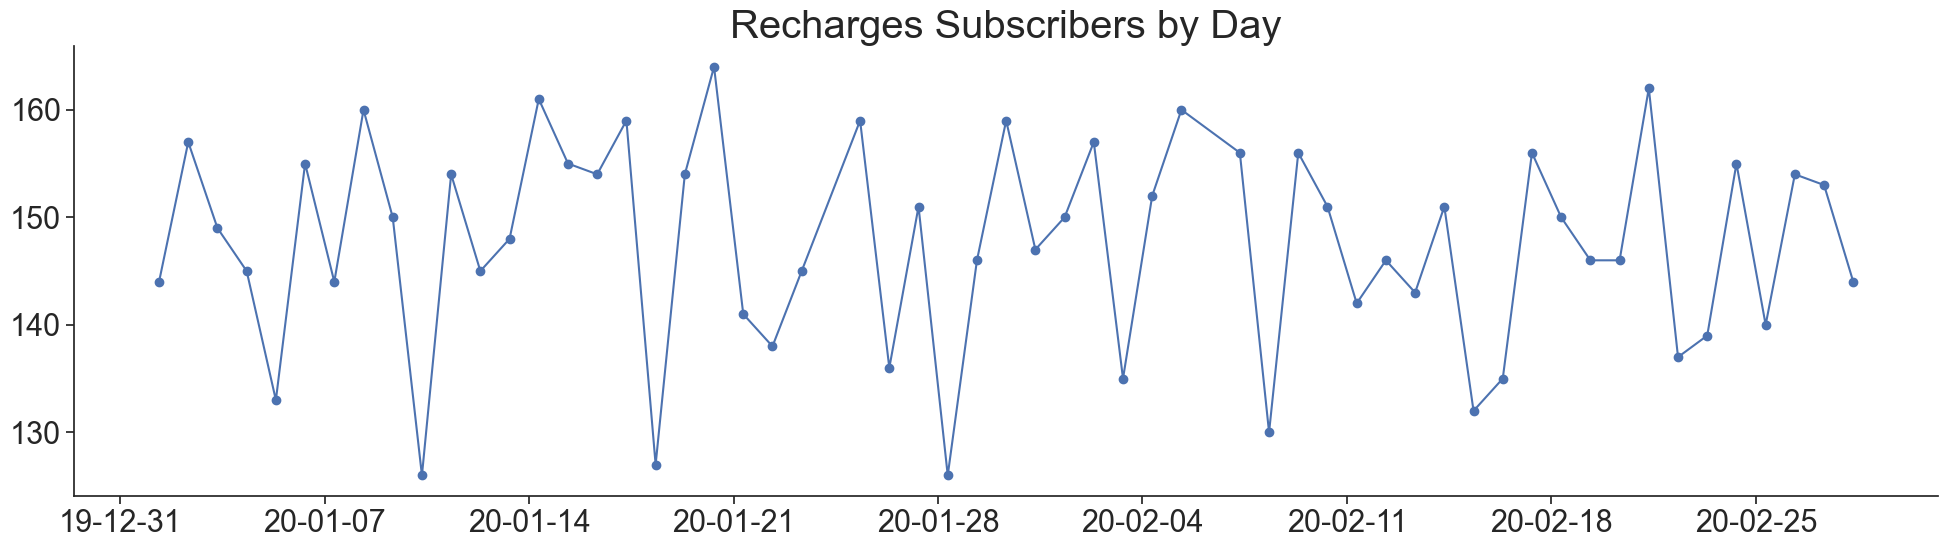

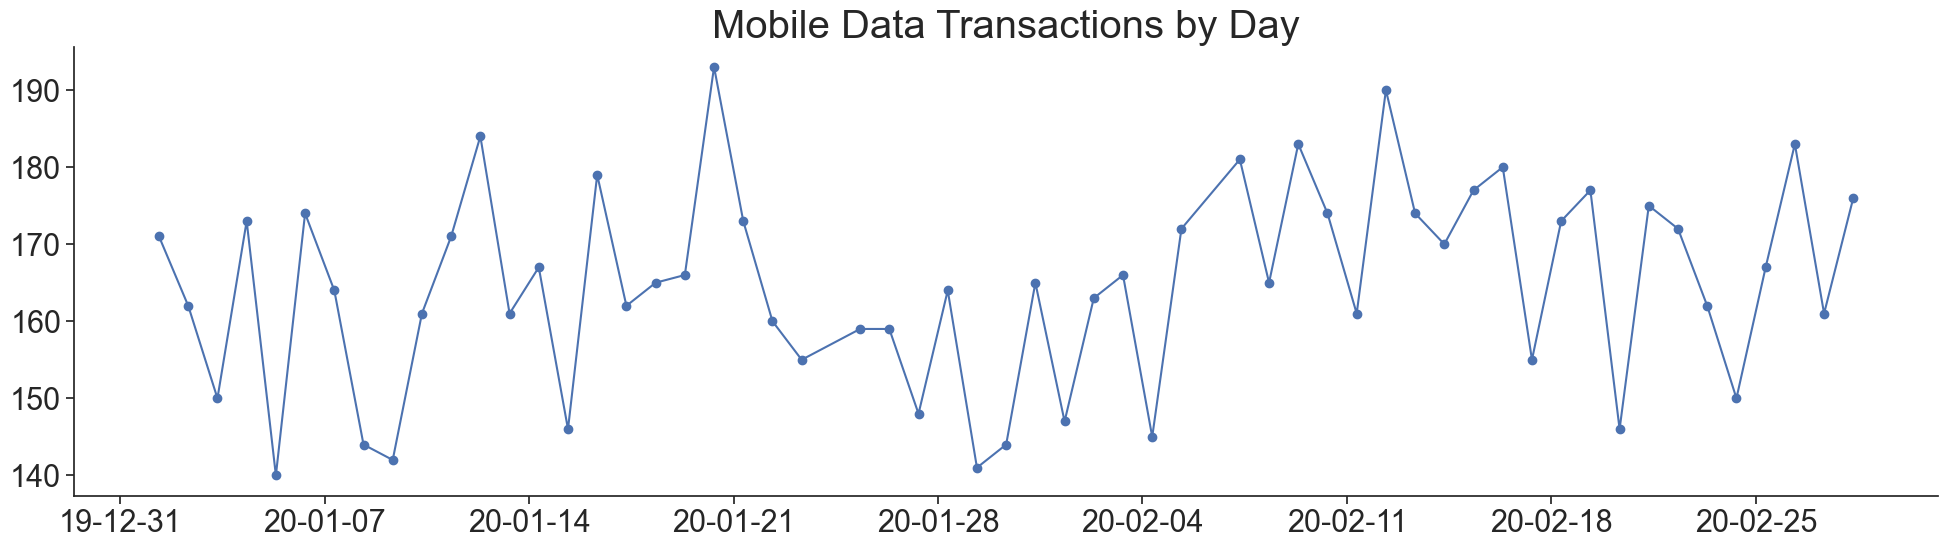

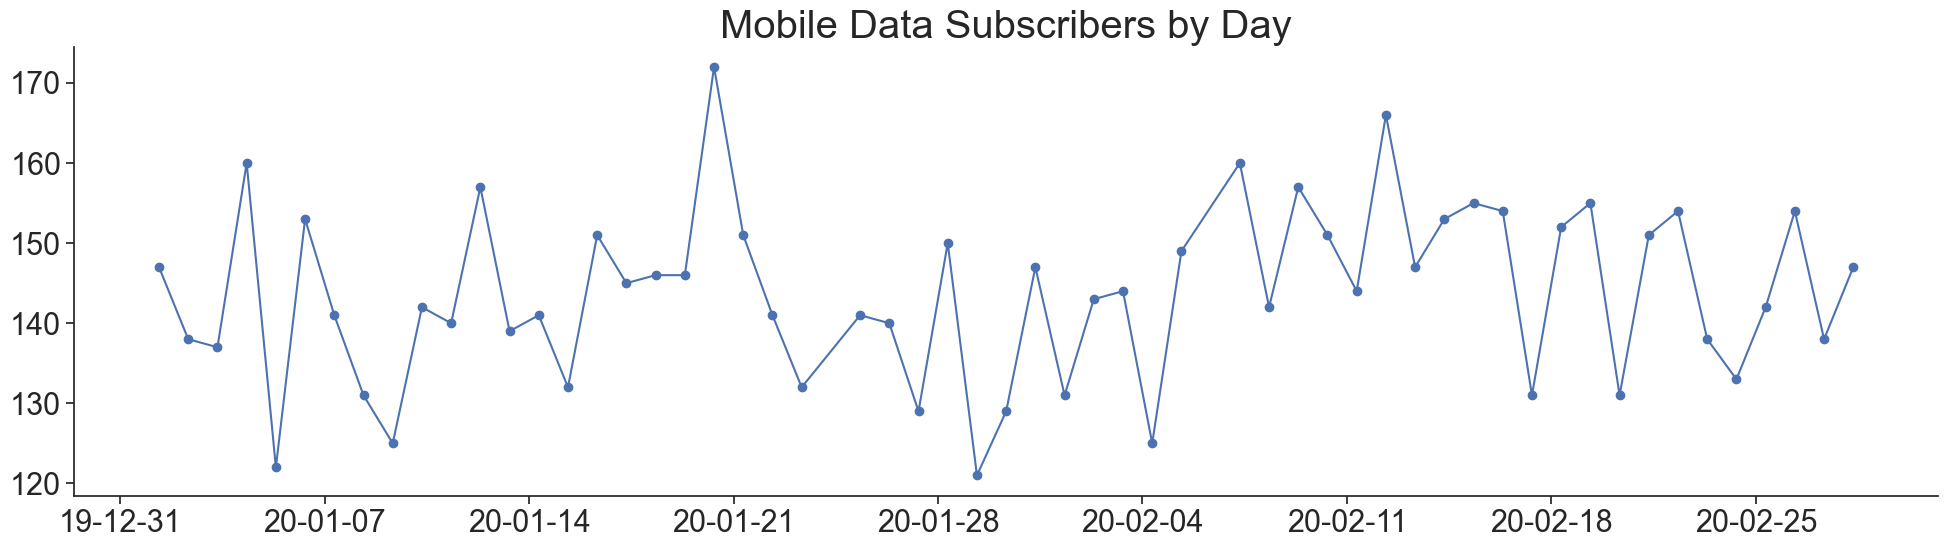

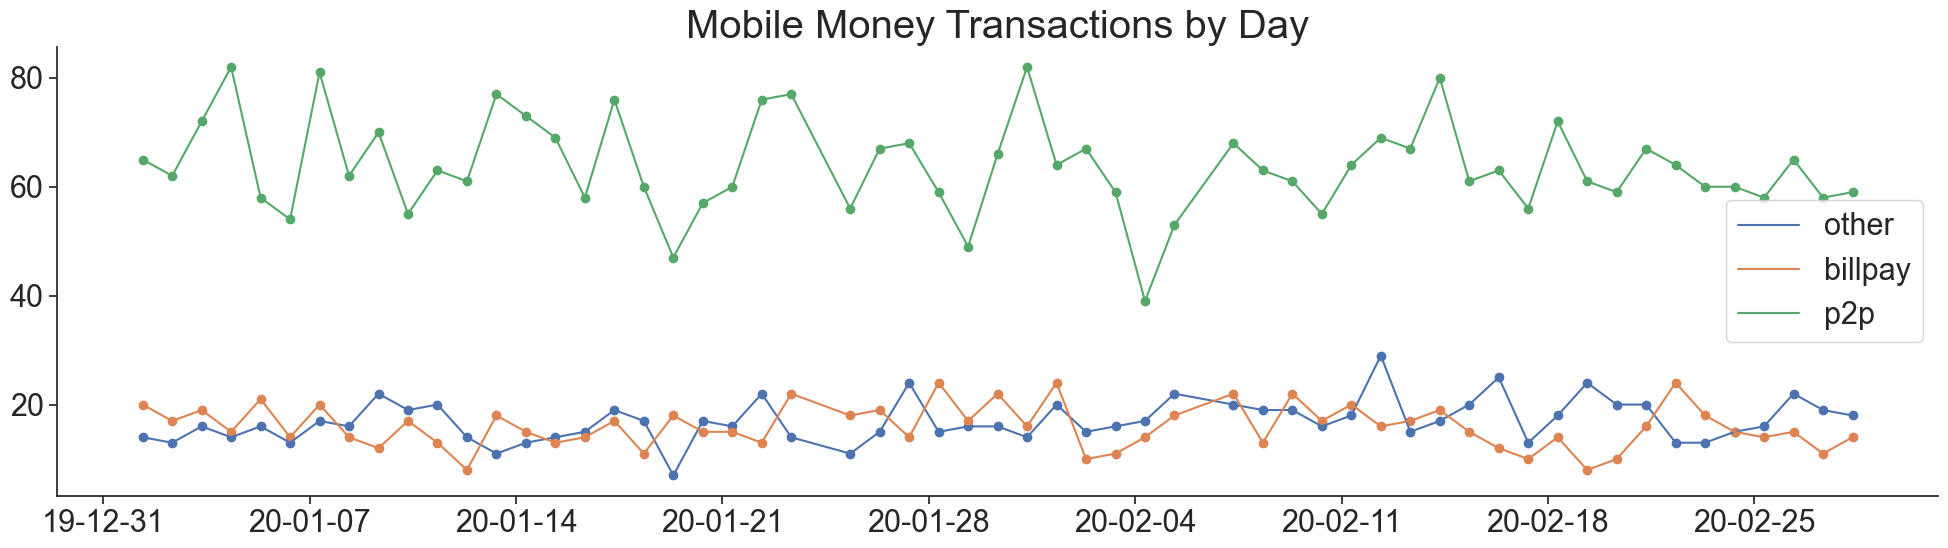

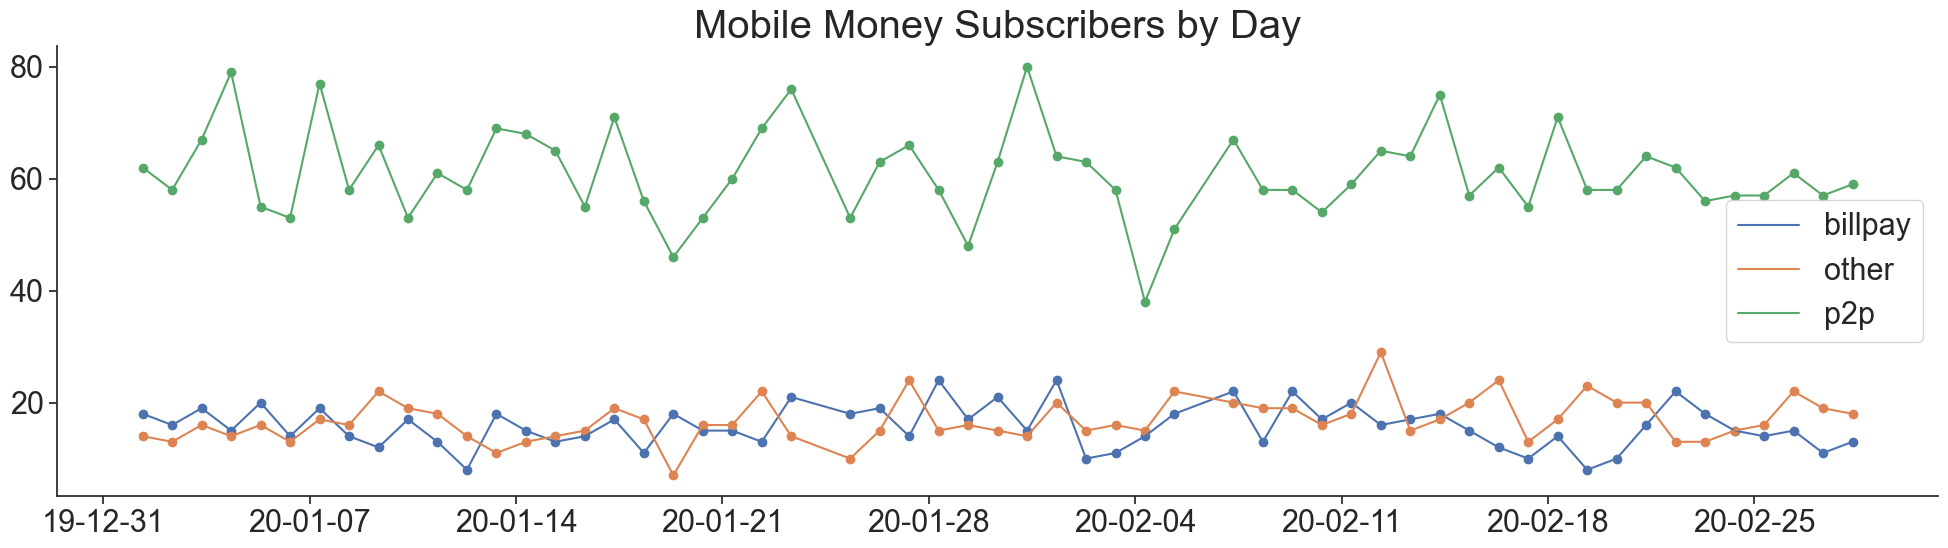

In [6]:
featurizer.diagnostic_plots()

Featurize the data

In [5]:
featurizer.cdr_features_spark()
featurizer.international_features()
featurizer.location_features()
featurizer.recharges_features()
featurizer.mobiledata_features()
featurizer.mobilemoney_features()

featurizer.all_features()

Calculating CDR features...


Calculating international features...


Calculating spatial features...


/Users/leo/miniconda3/envs/cider3.9/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/leo/Documents/gpl/cider/cider/featurizer.py:370: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  antennas = gpd.sjoin(antennas, shapefile, op='within', how='left').drop('index_right', axis=1)
/Users/leo/Documents/gpl/cider/cider/featurizer.py:370: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input g

Calculating recharges features...
Calculating mobile data features...
Calculating mobile money features...


Now we read the features back with pandas in to see what the table looks like. This works fine because our synthetic dataset is small, but such files can be too large to fit in memory if the number of subscribers is large; Cider uses [pyspark](https://spark.apache.org/docs/latest/api/python/) to manage large datasets. Another option for working with large datasets is [dask](https://www.dask.org/).

In [6]:
import pandas as pd
path_to_all_features = datastore.cfg.path.working.directory_path / 'featurizer' / 'datasets' / 'features.csv'
pd.read_csv(path_to_all_features, dtype={'name': str}).head(100)

,name,active_days_allweek_allday,active_days_allweek_day,active_days_allweek_night,active_days_weekday_allday,active_days_weekday_day,active_days_weekday_night,active_days_weekend_allday,active_days_weekend_day,active_days_weekend_night,...,mobilemoney_outgoing_p2p_amount_min,mobilemoney_outgoing_p2p_amount_max,mobilemoney_outgoing_p2p_balance_before_mean,mobilemoney_outgoing_p2p_balance_before_min,mobilemoney_outgoing_p2p_balance_before_max,mobilemoney_outgoing_p2p_balance_after_mean,mobilemoney_outgoing_p2p_balance_after_min,mobilemoney_outgoing_p2p_balance_after_max,mobilemoney_outgoing_p2p_txns,mobilemoney_outgoing_p2p_contacts
0,1068395,54,46,46,38,33,32,16,13,14,...,30.222473,70.803710,206.221286,180.20338,239.67809,158.092635,109.399680,185.19756,6.0,6.0
1,1088875,55,45,48,39,34,32,16,11,16,...,36.724060,65.197014,174.832893,94.95520,260.03677,125.468370,58.231140,209.75879,4.0,4.0
2,1151815,52,43,42,36,30,29,16,13,13,...,25.403230,69.630840,197.661448,143.49661,251.89214,151.198061,101.536630,226.48890,9.0,9.0
3,1155381,56,46,42,40,33,28,16,13,14,...,35.615395,63.297916,205.654711,158.98051,267.41220,152.560454,101.690550,214.87619,7.0,7.0
4,1159103,53,42,42,38,32,28,15,10,14,...,43.855840,65.405270,197.622427,157.64932,236.83188,147.132861,111.951840,192.97603,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4042803,55,42,50,39,32,35,16,10,15,...,44.085785,69.810104,209.323082,135.56276,246.69228,154.552682,88.004130,200.23488,6.0,6.0
96,4043022,55,44,46,39,32,32,16,12,14,...,31.741247,66.080310,211.444359,167.15100,280.66760,162.220635,112.452990,225.88815,10.0,10.0
97,4044894,54,44,47,39,31,34,15,13,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,4124137,55,48,42,39,36,29,16,12,13,...,52.455593,56.009243,217.303070,176.89285,257.71330,163.070656,120.883606,205.25770,2.0,2.0


Plot the distributions of some of the features.

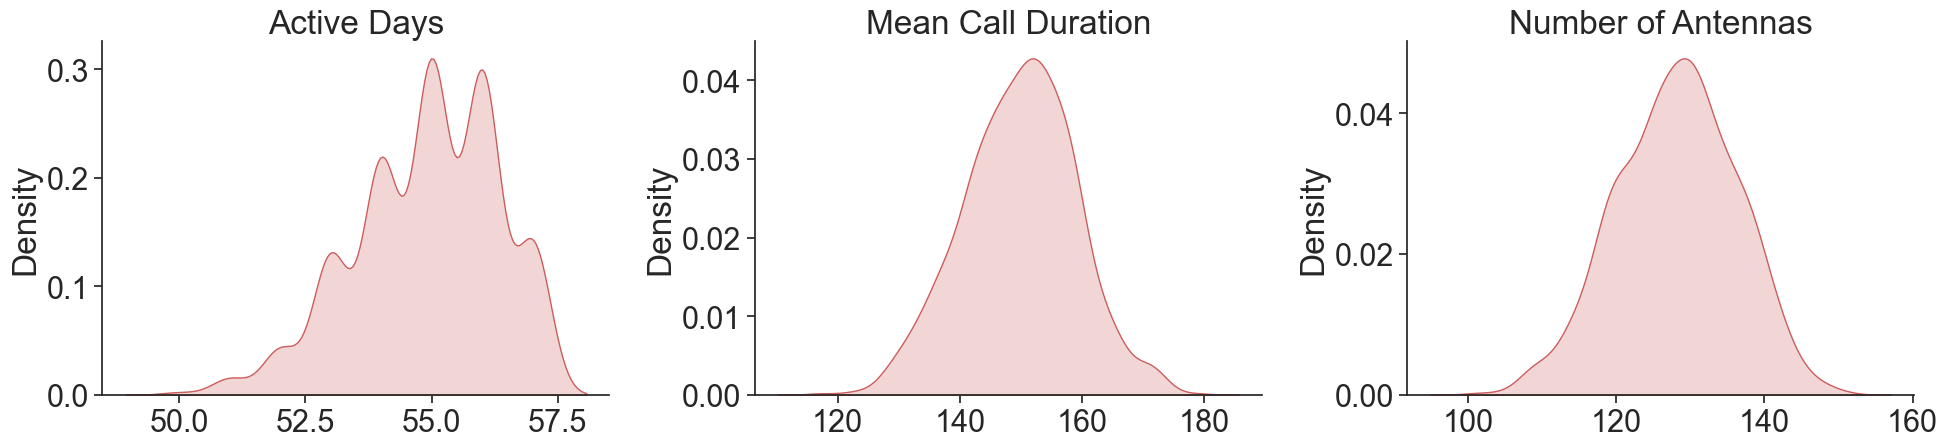

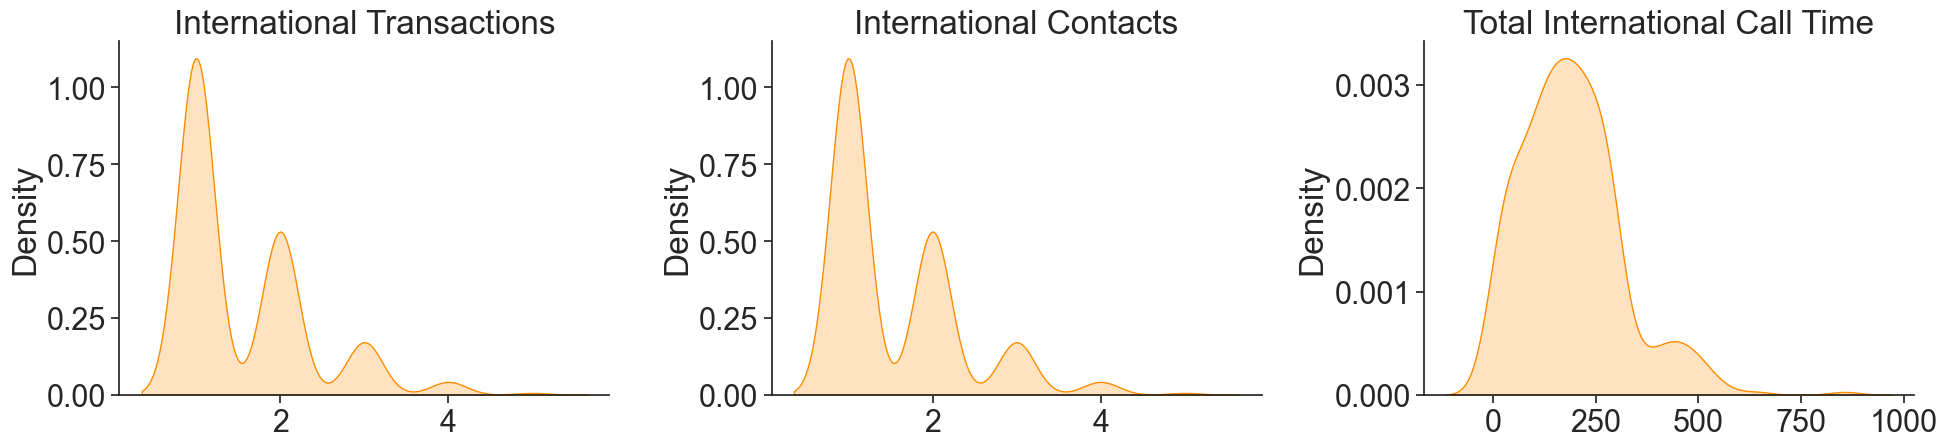

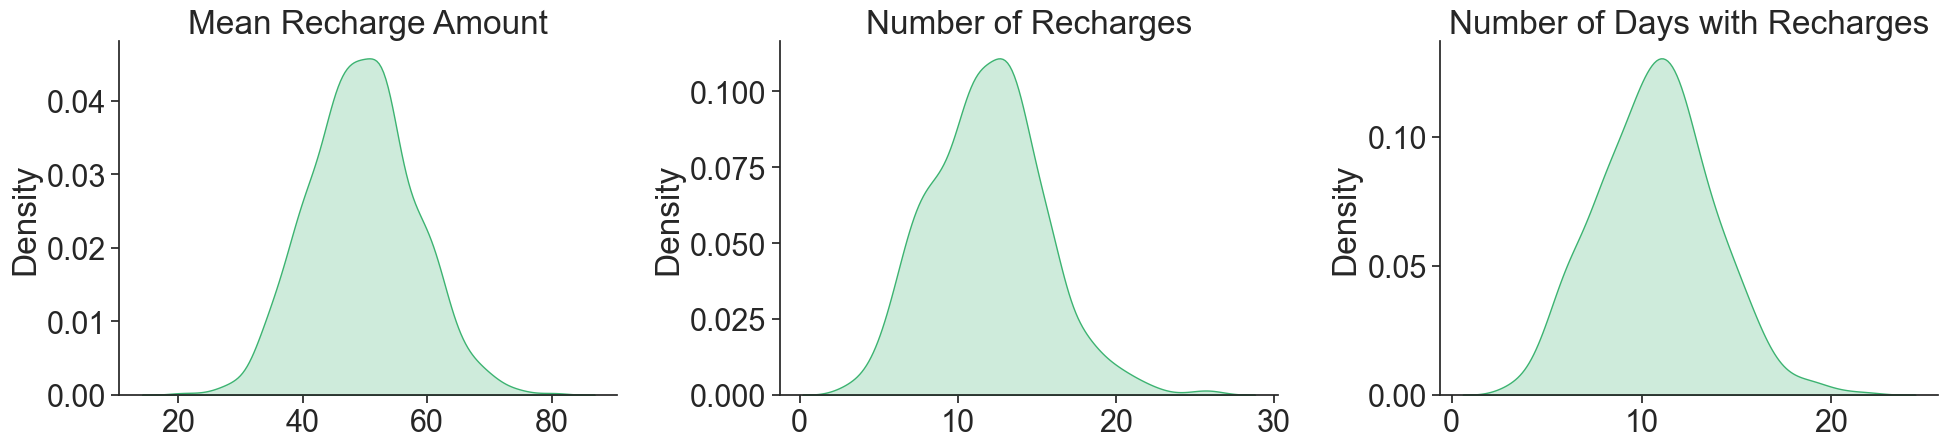

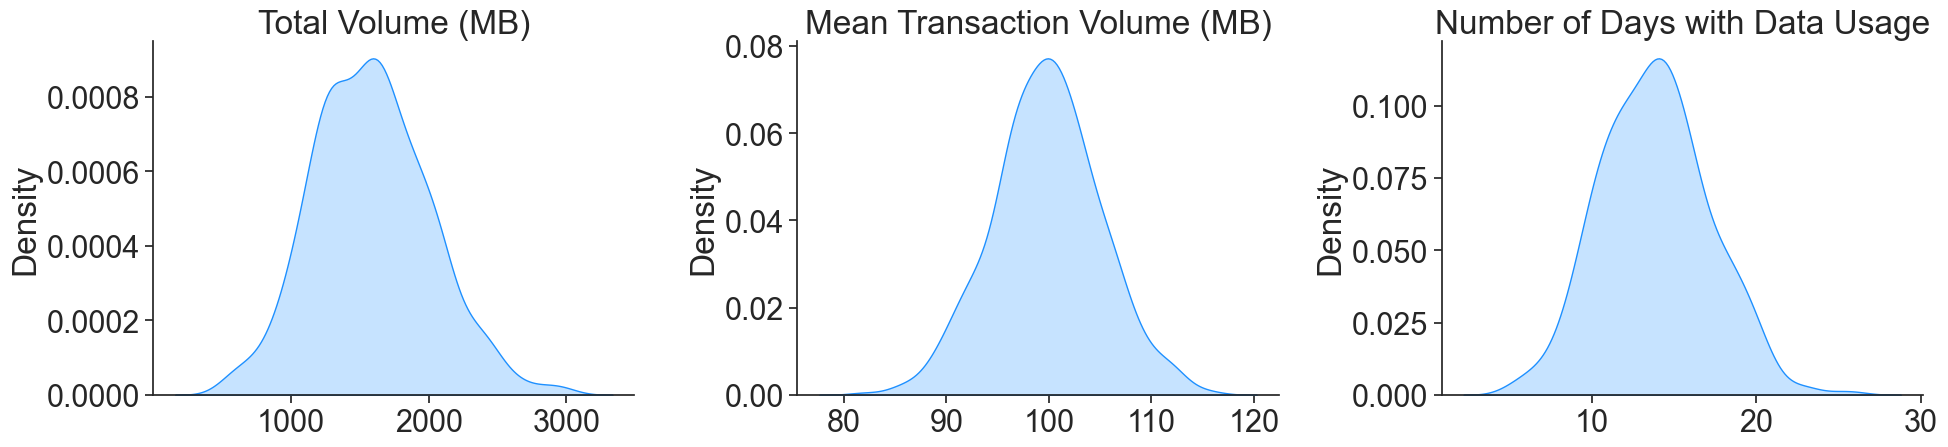

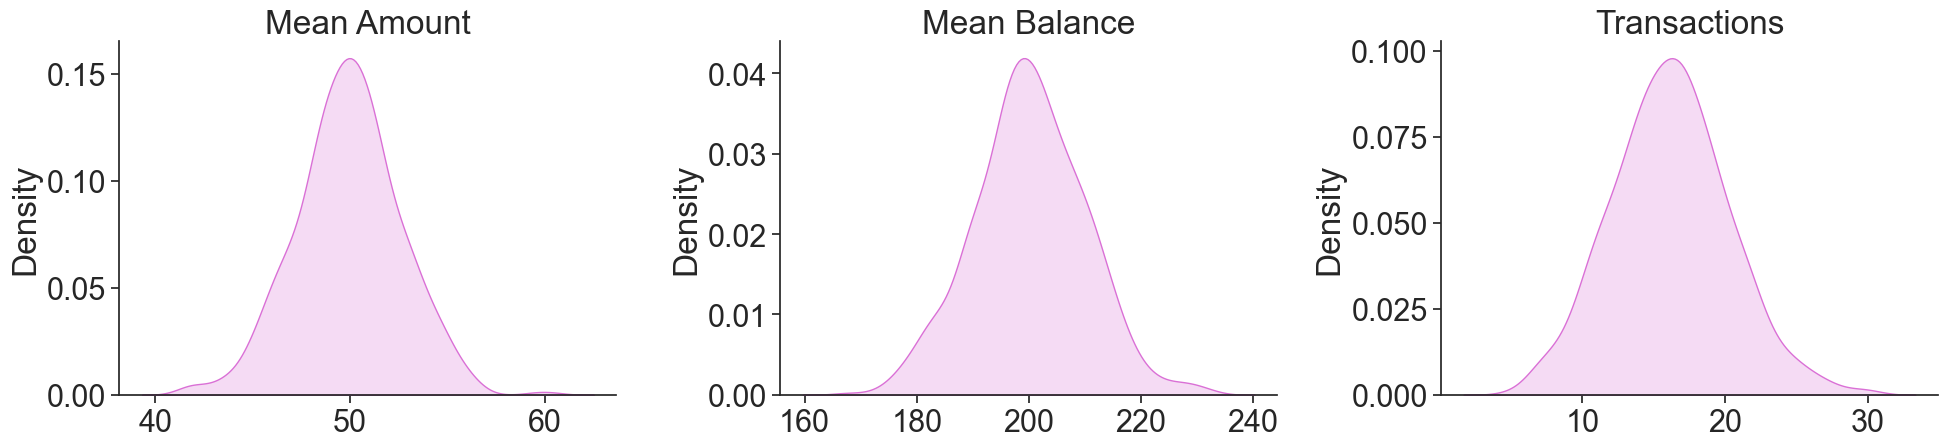

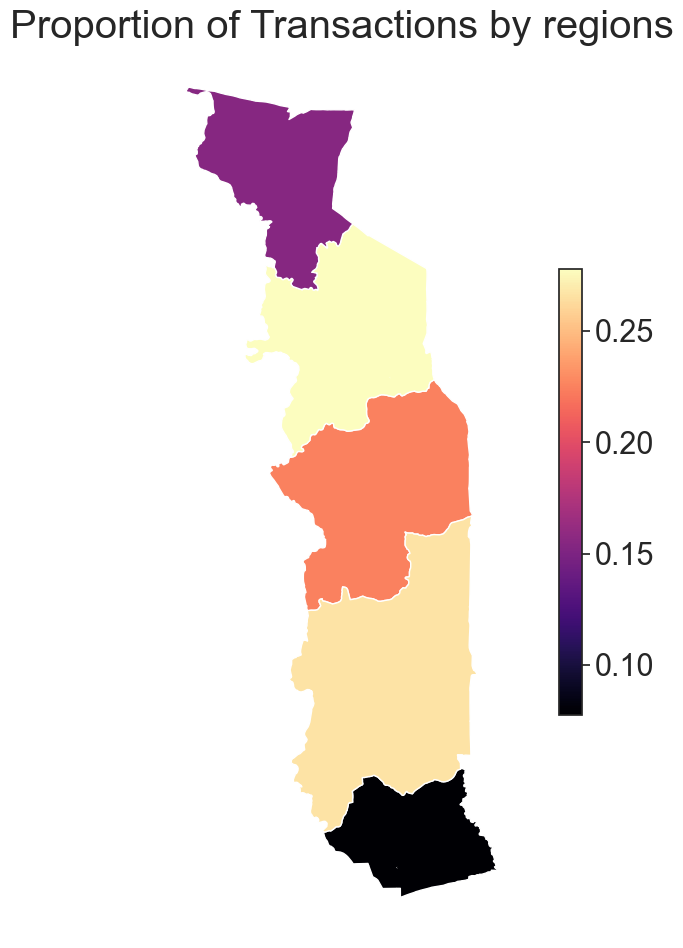

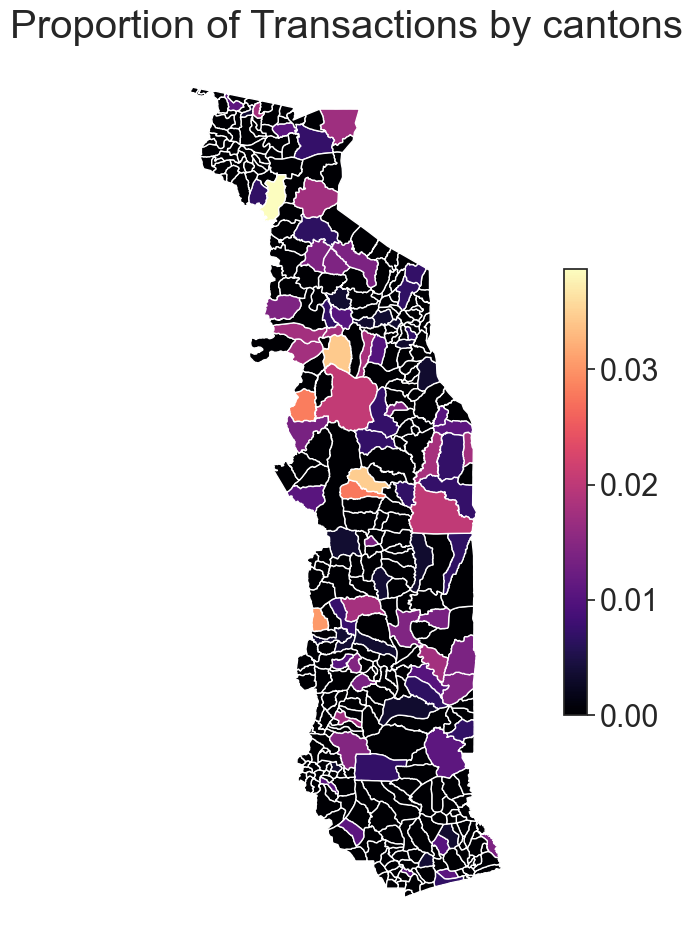

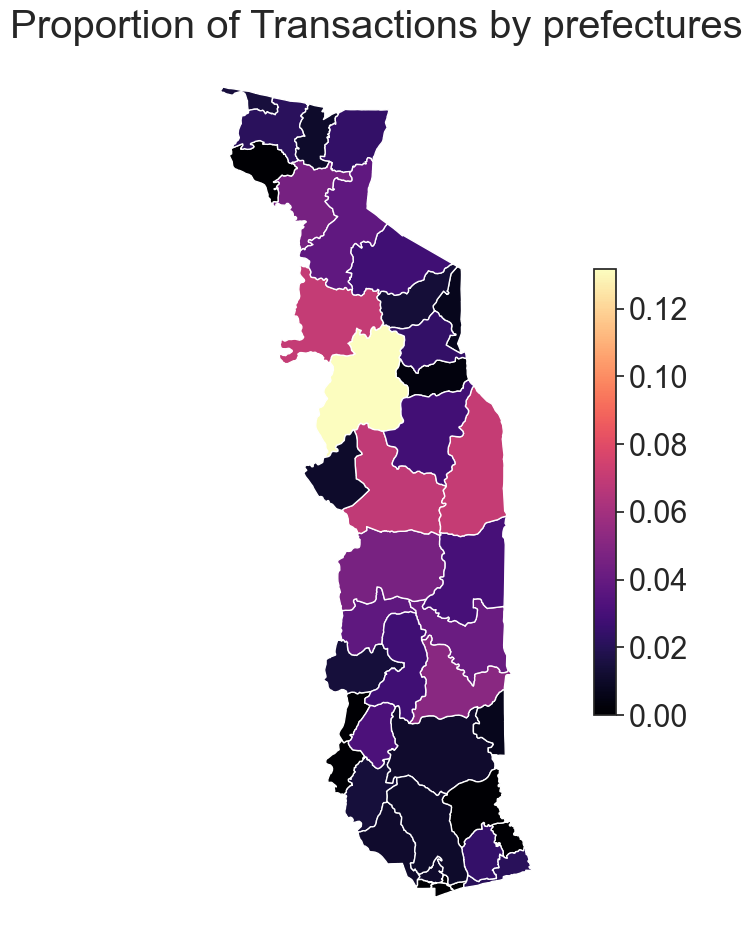

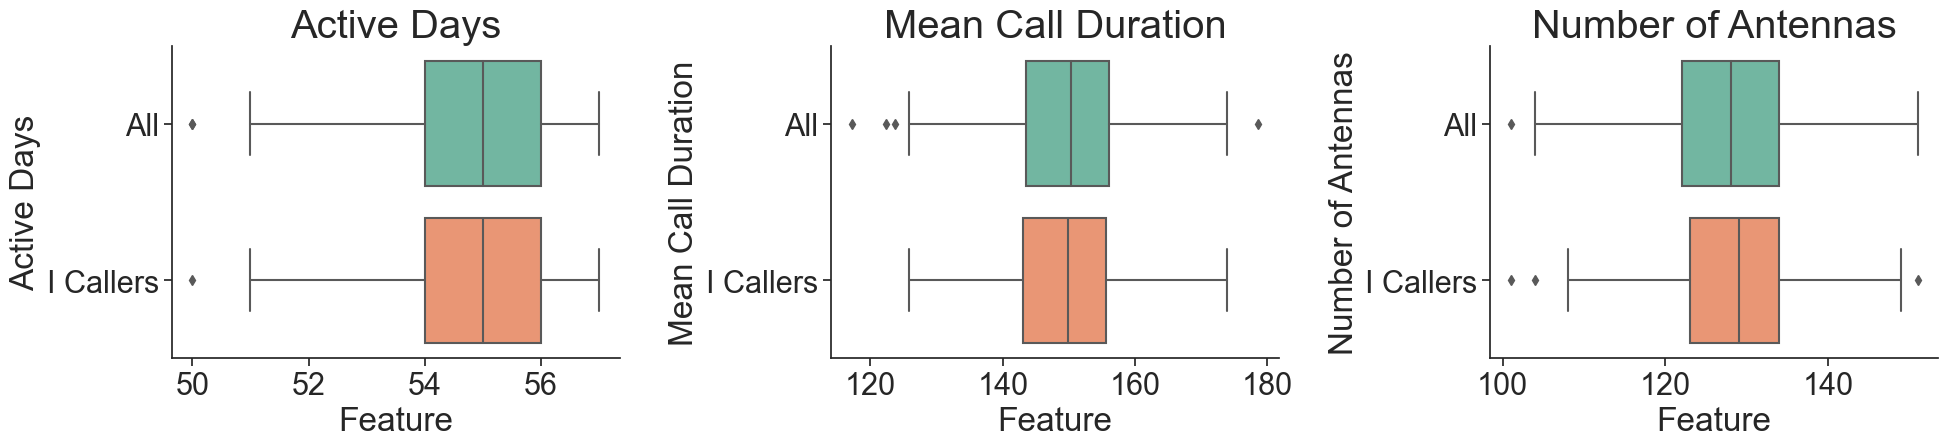

In [10]:
featurizer.feature_plots()

In [18]:
featurizer.features['cdr'].toPandas().head()

,name,active_days_allweek_allday,active_days_allweek_day,active_days_allweek_night,active_days_weekday_allday,active_days_weekday_day,active_days_weekday_night,active_days_weekend_allday,active_days_weekend_day,active_days_weekend_night,...,frequent_antennas_weekend_night,percent_at_home_allweek_allday,percent_at_home_allweek_day,percent_at_home_allweek_night,percent_at_home_weekday_allday,percent_at_home_weekday_day,percent_at_home_weekday_night,percent_at_home_weekend_allday,percent_at_home_weekend_day,percent_at_home_weekend_night
0,8800180230345,54,46,46,38,33,32,16,13,14,...,19,0.022472,0.0,0.050633,0.032000,0.0,0.072727,0.000000,0.0,0.000000
1,8800180243041,56,51,44,41,36,32,15,15,12,...,19,0.015625,0.0,0.034091,0.021429,0.0,0.045455,0.000000,0.0,0.000000
2,8800180289747,57,45,45,41,34,32,16,11,13,...,24,0.018987,0.0,0.036585,0.019608,0.0,0.039216,0.017857,0.0,0.032258
3,8800180319649,54,47,46,40,35,33,14,12,13,...,19,0.012903,0.0,0.027778,0.017544,0.0,0.041667,0.000000,0.0,0.000000
4,8800180525857,53,41,44,39,31,33,14,10,11,...,16,0.018750,0.0,0.037037,0.024000,0.0,0.049180,0.000000,0.0,0.000000
